# Model Training and Predictions

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.feature_selection import chi2, f_regression, f_classif, mutual_info_classif, mutual_info_regression 
from sklearn.feature_selection import SelectKBest, SelectFromModel, VarianceThreshold
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model as lm
from sklearn import neighbors
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import model_selection as ms

sklearn.set_config(print_changed_only=False)

import xgboost as xgb

from matplotlib import pyplot as plt

from ipynb.fs.full.functions_sheet import col_obj_list, nan_col_list, cols_nan_unique, nan_col_obj_list_fillna
from ipynb.fs.full.functions_sheet import fill_masvnrtype, rmse

In [2]:
hp_tree_fullyimputed = pd.read_csv('../hp_tree_fullyimputed.csv')
hp_linear_fullyimputed = pd.read_csv('../hp_linear_fullyimputed.csv')

hp_tree_fullyimputed

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,GarageYrModified
0,60,6,65.0,8450,2,0,1,1,1,1,1,6,3,3,1,4,7,5,2003,2003,2,2,15,15,2,196.0,2,3,3,2,3,4,1,706,6,0,150,856,2,1,1,1,856,854,0,1710,1,0,2,1,3,1,2,8,1,0,0,2,2003.0,2,2,548,3,3,1,0,61,0,0,0,0,0,0,0,0,2,2008,1,1,2003
1,20,6,80.0,9600,2,0,1,1,1,4,1,25,2,3,1,1,6,8,1976,1976,2,2,9,9,4,0.0,3,3,2,2,3,1,2,978,6,0,284,1262,2,1,1,1,1262,0,0,1262,0,1,2,0,3,1,3,6,1,1,3,2,1976.0,2,2,460,3,3,1,298,0,0,0,0,0,0,0,0,0,5,2007,1,1,1976
2,60,6,68.0,11250,2,0,2,1,1,1,1,6,3,3,1,4,7,5,2001,2002,2,2,15,15,2,162.0,2,3,3,2,3,3,1,486,6,0,434,920,2,1,1,1,920,866,0,1786,1,0,2,1,3,1,2,6,1,1,3,2,2001.0,2,2,608,3,3,1,0,42,0,0,0,0,0,0,0,0,9,2008,1,1,2001
3,70,6,60.0,9550,2,0,2,1,1,2,1,7,3,3,1,4,7,5,1915,1970,2,2,16,17,4,0.0,3,3,1,3,2,4,2,216,6,0,540,756,2,2,1,1,961,756,0,1717,1,0,1,0,3,1,2,7,1,1,2,6,1998.0,3,3,642,3,3,1,0,35,272,0,0,0,0,0,0,0,2,2006,1,2,1915
4,60,6,84.0,14260,2,0,2,1,1,4,1,14,3,3,1,4,8,5,2000,2000,2,2,15,15,2,350.0,2,3,3,2,3,2,1,655,6,0,490,1145,2,1,1,1,1145,1053,0,2198,1,0,2,1,4,1,2,9,1,1,3,2,2000.0,2,3,836,3,3,1,192,84,0,0,0,0,0,0,0,0,12,2008,1,1,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,6,62.0,7917,2,0,1,1,1,1,1,9,3,3,1,4,6,5,1999,2000,2,2,15,15,4,0.0,3,3,3,2,3,4,6,0,6,0,953,953,2,1,1,1,953,694,0,1647,0,0,2,1,3,1,3,7,1,1,3,2,1999.0,2,2,460,3,3,1,0,40,0,0,0,0,0,0,0,0,8,2007,1,1,1999
1456,20,6,85.0,13175,2,0,1,1,1,1,1,17,3,3,1,1,6,6,1978,1988,2,2,11,11,5,119.0,3,3,2,2,3,4,2,790,4,163,589,1542,2,3,1,1,2073,0,0,2073,1,0,2,0,3,1,3,7,2,2,3,2,1978.0,3,2,500,3,3,1,349,0,0,0,0,0,0,2,0,0,2,2010,1,1,1978
1457,70,6,66.0,9042,2,0,1,1,1,1,1,7,3,3,1,4,7,9,1941,2006,2,2,6,6,4,0.0,1,2,5,3,2,4,1,275,6,0,877,1152,2,1,1,1,1188,1152,0,2340,0,0,2,0,4,1,2,9,1,2,2,2,1941.0,2,1,252,3,3,1,0,60,0,0,0,0,0,1,4,2500,5,2010,1,1,1941
1458,20,6,68.0,9717,2,0,1,1,1,1,1,13,3,3,1,1,5,6,1950,1996,4,2,9,9,4,0.0,3,3,2,3,3,3,1,49,4,1029,0,1078,2,2,1,2,1078,0,0,1078,1,0,1,0,2,1,2,5,1,0,0,2,1950.0,3,1,240,3,3,1,366,0,112,0,0,0,0,0,0,0,4,2010,1,1,1950


In [3]:
hp_linear_fullyimputed

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,GarageYrModified,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_DNE,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_DNE,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_DNE,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_DNE,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_DNE,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_DNE,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_DNE,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_DNE,GarageTy

In [4]:
hp_logsaleprice = pd.read_csv('../hp_logsaleprice.csv')

hp_logsaleprice

,SalePrice
0,12.247694
1,12.109011
2,12.317167
3,11.849398
4,12.429216
...,...
1455,12.072541
1456,12.254863
1457,12.493130
1458,11.864462


## Penalized Linear Regressions

In [6]:
xtrain, xtest, ytrain, ytest = ms.train_test_split(hp_linear_fullyimputed, hp_logsaleprice, test_size=0.2, random_state=0)

In [7]:
ytrain = ytrain.values.flatten()

In [8]:
# defrmse = np.sqrt(mean_squared_error(gs_lasso.predict(xtrain)))

In [9]:
lasso = Lasso(random_state=0, max_iter=1000000, normalize=True)

# n_folds_lin = ms.StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

n_folds_lin = ms.KFold(n_splits=5, random_state=0, shuffle=True)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000000, normalize=True, positive=False,
                             precompute=False, random_state=0,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e-08, 2.04081634e+00, 4...
       6.53061225e+01, 6.73469388e+01, 6.93877551e+01, 7.14285714e+01,
       7.34693878e+01, 7.55102041e+01, 7.75510204e+01, 7.95918367e+01,
       8.16326531e+01, 8.36734694e+01, 8.57142857e+01, 8.77551020e+01,
       8.97959184e+01, 9.18367347e+01, 9.38775510e+01, 9.59183673e+01,
       9.79591837e+01, 1.00000000e+02])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_root_mean_squared_error', verbose=0)
######################

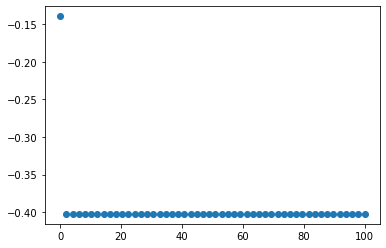

In [10]:
alphas = np.linspace(1e-8, 1e2, 50)

gparam_lasso = [{'alpha': alphas}]

gs_lasso = GridSearchCV(lasso, gparam_lasso, cv=n_folds_lin, scoring='neg_root_mean_squared_error', return_train_score=True)

print(gs_lasso.fit(xtrain, ytrain))

print('#'*50)
print('\n')

print('Currently, the best parameters are: ', gs_lasso.best_params_)

print('where the alpha is: ', gs_lasso.best_params_['alpha'])

print('#'*50)
print('\n')

print('The best score is: ', gs_lasso.best_estimator_.score(xtrain, ytrain))

print('#'*50)
print('\n')

print('The RMSE is: ', rmse(gs_lasso, ytrain, xtrain))

plt.scatter(gs_lasso.cv_results_['param_alpha'], gs_lasso.cv_results_['mean_test_score'])

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000000, normalize=True, positive=False,
                             precompute=False, random_state=0,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e-08, 3.44924138e-05, 6...
       4.13798966e-04, 4.48281379e-04, 4.82763793e-04, 5.17246207e-04,
       5.51728621e-04, 5.86211034e-04, 6.20693448e-04, 6.55175862e-04,
       6.89658276e-04, 7.24140690e-04, 7.58623103e-04, 7.93105517e-04,
       8.27587931e-04, 8.62070345e-04, 8.96552759e-04, 9.31035172e-04,
       9.65517586e-04, 1.00000000e-03])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_root_mean_squared_error', verbose=0)
######################

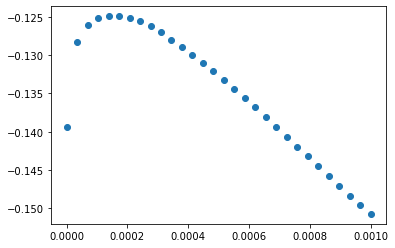

In [11]:
alphas = np.linspace(1e-8, 1e-3, 30)

gparam_lasso = [{'alpha': alphas}]

gs_lasso = GridSearchCV(lasso, gparam_lasso, cv=n_folds_lin, scoring='neg_root_mean_squared_error', return_train_score=True)

print(gs_lasso.fit(xtrain, ytrain))

print('#'*50)
print('\n')

print('Currently, the best parameters are: ', gs_lasso.best_params_)

print('where the alpha is: ', gs_lasso.best_params_['alpha'])

print('#'*50)
print('\n')

print('The best score is: ', gs_lasso.best_estimator_.score(xtrain, ytrain))

print('#'*50)
print('\n')

print('The RMSE is: ', rmse(gs_lasso, ytrain, xtrain))

plt.scatter(gs_lasso.cv_results_['param_alpha'], gs_lasso.cv_results_['mean_test_score'])

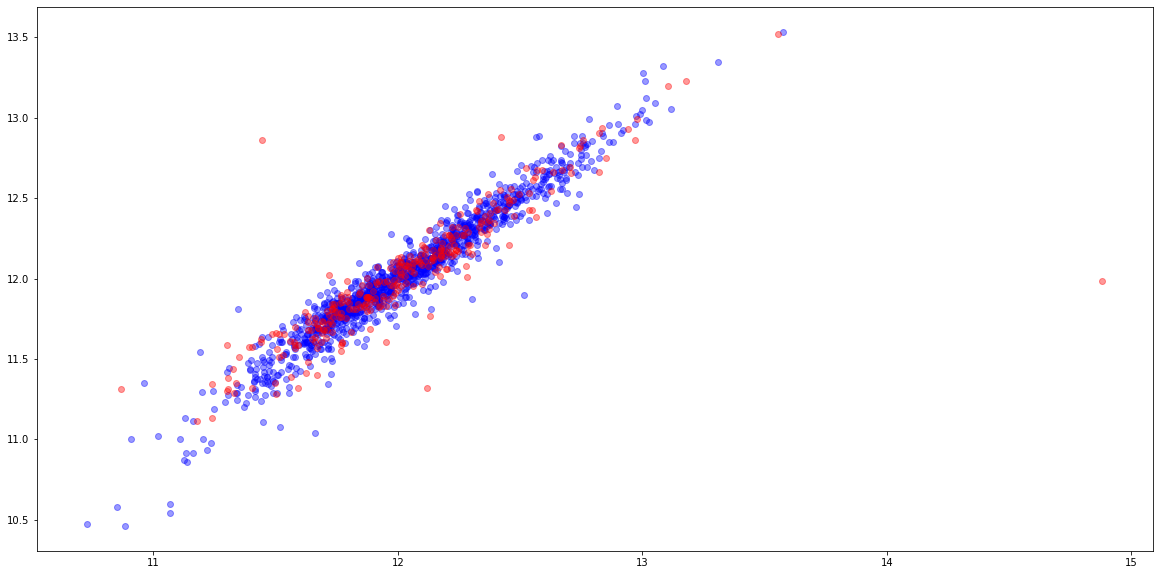

In [22]:
plt.figure(figsize=(20, 10))
plt.scatter(gs_lasso.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_lasso.predict(xtest), ytest, color='red', alpha=0.4)

In [38]:
lasso = Lasso(alpha=gs_lasso.best_params_['alpha'], random_state=0, max_iter=1000000, normalize=True)

lasso.fit(xtrain, ytrain)

pd.Series(lasso.coef_, index=xtrain.columns).sort_values(ascending=False).head(50)

GrLivArea               1.360234e-01
Neighborhood_Crawfor    9.401103e-02
OverallQual             8.517451e-02
PoolQC_Gd               7.278962e-02
KitchenQual_Ex          5.587915e-02
TotalBsmtSF             4.912338e-02
SaleType_New            4.134057e-02
Functional_Typ          3.920324e-02
OverallCond             3.476582e-02
BsmtQual_Ex             3.309072e-02
BsmtExposure_Gd         3.295466e-02
GarageCond_TA           3.181247e-02
Neighborhood_ClearCr    3.020194e-02
Neighborhood_StoneBr    2.778588e-02
BsmtFinSF1              2.667254e-02
GarageCars              2.643338e-02
Exterior1st_BrkFace     2.500923e-02
LotConfig_CulDSac       2.328758e-02
GarageQual_Gd           2.311059e-02
Condition1_Norm         2.214589e-02
GarageYrModified        2.208258e-02
HeatingQC_Ex            2.039163e-02
YearRemodAdd            1.893048e-02
YearBuilt               1.777100e-02
MSZoning_FV             1.762178e-02
Foundation_PConc        1.736564e-02
Neighborhood_NridgHt    1.617738e-02
B

C:\Users\tdcho\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Wall time: 1min 59s
{'alpha': 0.035622478902624426}
0.8292901855000376


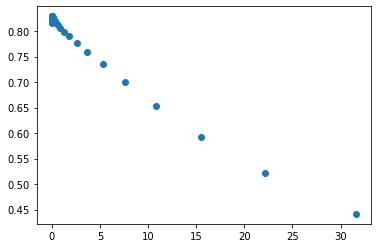

In [14]:
enet = ElasticNet(random_state=0, max_iter=10000)

alphas = np.logspace(-3, 1.5, 30)
rhos = np.logspace(-3, 1.5, 30)

gparam_enet = [{'alpha': alphas},
               {'l1_ratio': rhos}]
n_folds=ms.StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

gs_enet = GridSearchCV(enet, gparam_enet, cv=n_folds, refit=True, n_jobs=-1)
%time gs_enet.fit(hp_linear_fullyimputed, hp_sp_flat)

print(gs_enet.best_params_)
print(gs_enet.best_score_)
plt.scatter(gs_enet.cv_results_['param_alpha'], gs_enet.cv_results_['mean_test_score'])

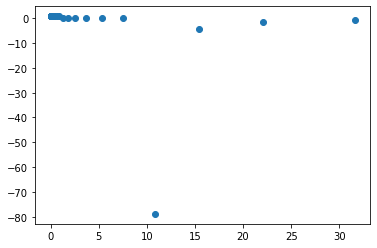

In [15]:
plt.scatter(gs_enet.cv_results_['param_l1_ratio'], gs_enet.cv_results_['mean_test_score'])

C:\Users\tdcho\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Wall time: 5min 31s
{'alpha': 0.1030204081632653}
0.8268839478135573


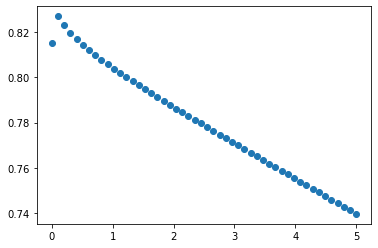

In [16]:
enet = ElasticNet(random_state=0, max_iter=10000)

alphas = np.linspace(1e-3, 5, 50)
rhos = np.linspace(1e-3, 5, 50)

gparam_enet = [{'alpha': alphas},
               {'l1_ratio': rhos}]
n_folds=ms.StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

gs_enet = GridSearchCV(enet, gparam_enet, cv=n_folds, refit=True, n_jobs=-1)
%time gs_enet.fit(hp_linear_fullyimputed, hp_sp_flat)

print(gs_enet.best_params_)
print(gs_enet.best_score_)
plt.scatter(gs_enet.cv_results_['param_alpha'], gs_enet.cv_results_['mean_test_score'])

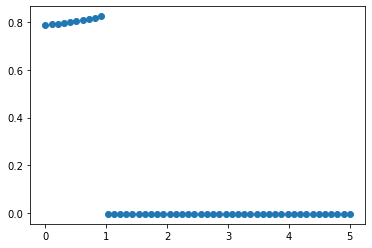

In [17]:
plt.scatter(gs_enet.cv_results_['param_l1_ratio'], gs_enet.cv_results_['mean_test_score'])

## Gradient Boosting Regressions

In [18]:
gbm = GradientBoostingRegressor(random_state=0, loss='ls',
                                min_impurity_decrease=0.1, 
                                warm_start=False)

learningrate = [0.0001, 0.001, 0.01, 0.1, 1] # subsequently, fine tune
nestimators = [5, 10, 50, 100, 200, 500, 1000,
               1500, 2000, 5000]
# subsamples = np.linspace(0, 1, 100)
maxfeatures = [9, 40, len(hp_tree_fullyimputed.columns)]
maxdepth = range(1, 5)

gparam_gbm = [{'learning_rate': learningrate},
              {'n_estimators': nestimators},
#               {'subsample': subsamples}, 
              {'max_features': maxfeatures},
              {'max_depth': maxdepth}]

n_folds=ms.StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

gs_gbm = GridSearchCV(gbm, gparam_gbm, cv=n_folds, refit=True, n_jobs=-1)
%time gs_gbm.fit(hp_tree_fullyimputed, hp_sp_flat)

C:\Users\tdcho\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Wall time: 1min 11s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.1,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,...
                                                 random_state=0, subsample=1.0,
                                                 tol=0.0001,
                      

In [19]:
print(gs_gbm.best_params_)
print(gs_gbm.best_score_)

{'max_depth': 4}
0.8914684915894397
